In [1]:
from source.diffusion_model import LatentDiffusionModel
from source.utils import WarmUp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 256

imdir = "D:/Datasets/MGG/new_patches"

train_imgs = tf.keras.utils.image_dataset_from_directory(
    imdir,
    labels=None,
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    seed=42,
    validation_split=0.1,
    subset="training",
)
val_imgs = tf.keras.utils.image_dataset_from_directory(
    imdir,
    labels=None,
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    seed=42,
    validation_split=0.1,
    subset="validation",
)

train_imgs = train_imgs.batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_imgs = val_imgs.batch(batch_size=BATCH_SIZE, drop_remainder=True)

def rescale(img):
    rescale_img = tf.keras.layers.Rescaling(scale=1.0 / 255.0)
    img = rescale_img(img)

    return img


train_ds = train_imgs.map(rescale)
val_ds = val_imgs.map(rescale)

train_ds = train_ds.cache()
val_ds = val_ds.cache()

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 48860 files belonging to 1 classes.
Using 43974 files for training.
Found 48860 files belonging to 1 classes.
Using 4886 files for validation.


In [4]:
vqgan = tf.keras.models.load_model("saved_model/vq_gan_256_model")

In [8]:
#calculate mean and variance of the training set

mean = 0
variance = 0

for k, img in enumerate(train_ds):
    mean += tf.math.reduce_mean(vqgan.vq_vae.encoder(img)) 
    variance += tf.math.reduce_variance(vqgan.vq_vae.encoder(img))

    if k % 10 == 0:
        print(f"\rBatch {k} processed", end="", flush=True)

mean /= k
variance /= k
mean = mean.numpy()
variance = variance.numpy()

print(f"\nMean: {mean}, Variance: {variance}")

Batch 1370 processed
Mean: 0.04818832129240036, Variance: 0.11266060918569565


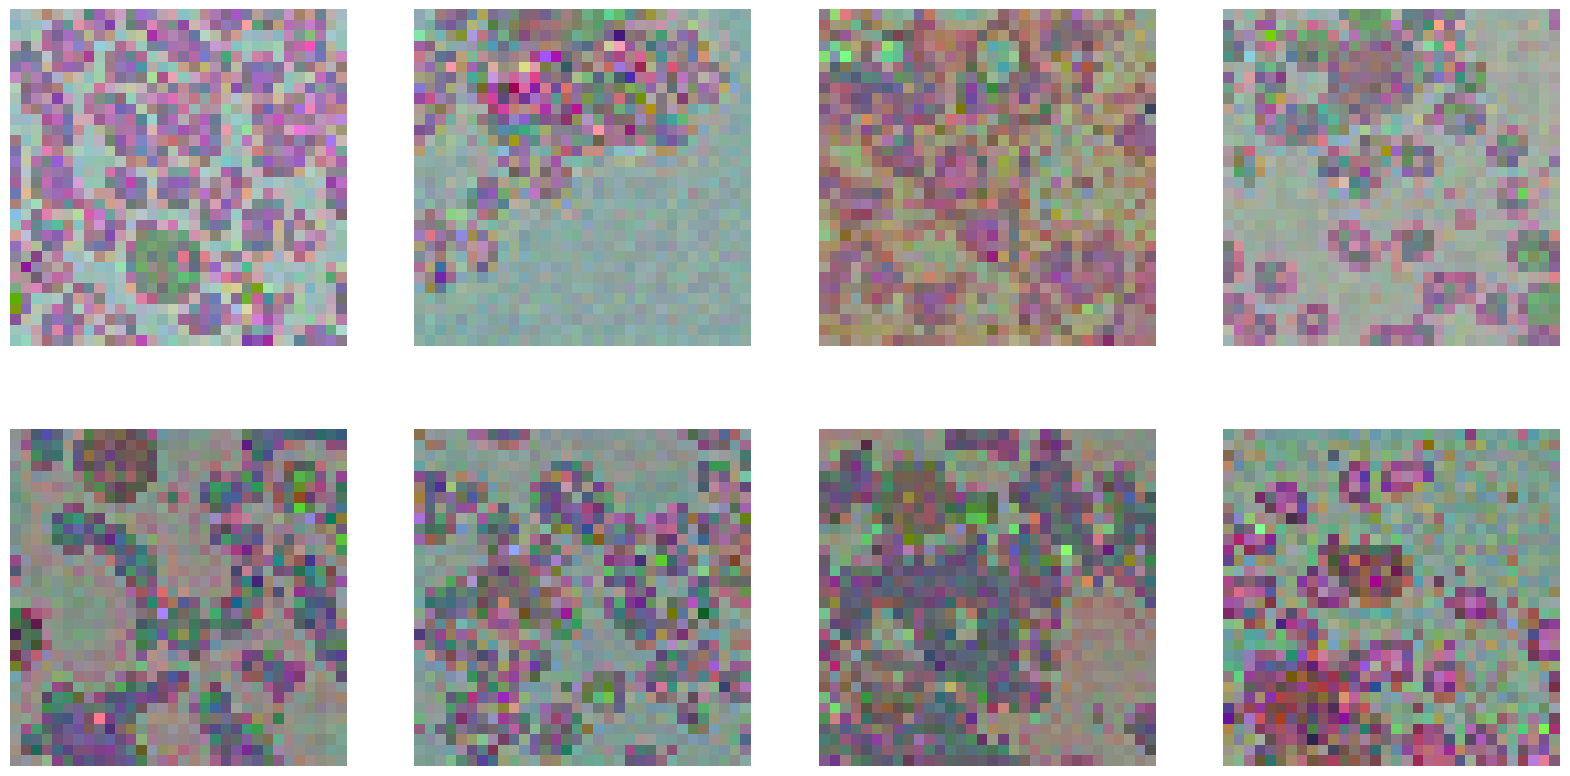

In [6]:
fig = plt.figure(figsize=(20, 10))
for img in val_ds.take(1):

    for i in range(8):
        x = vqgan.vq_vae.encoder(tf.expand_dims(img[i], axis=0))
        x = x.numpy().squeeze()

        #rescale the image to [0, 1]
        x = (x - x.min()) / (x.max() - x.min())

        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(x)
        ax.axis('off')

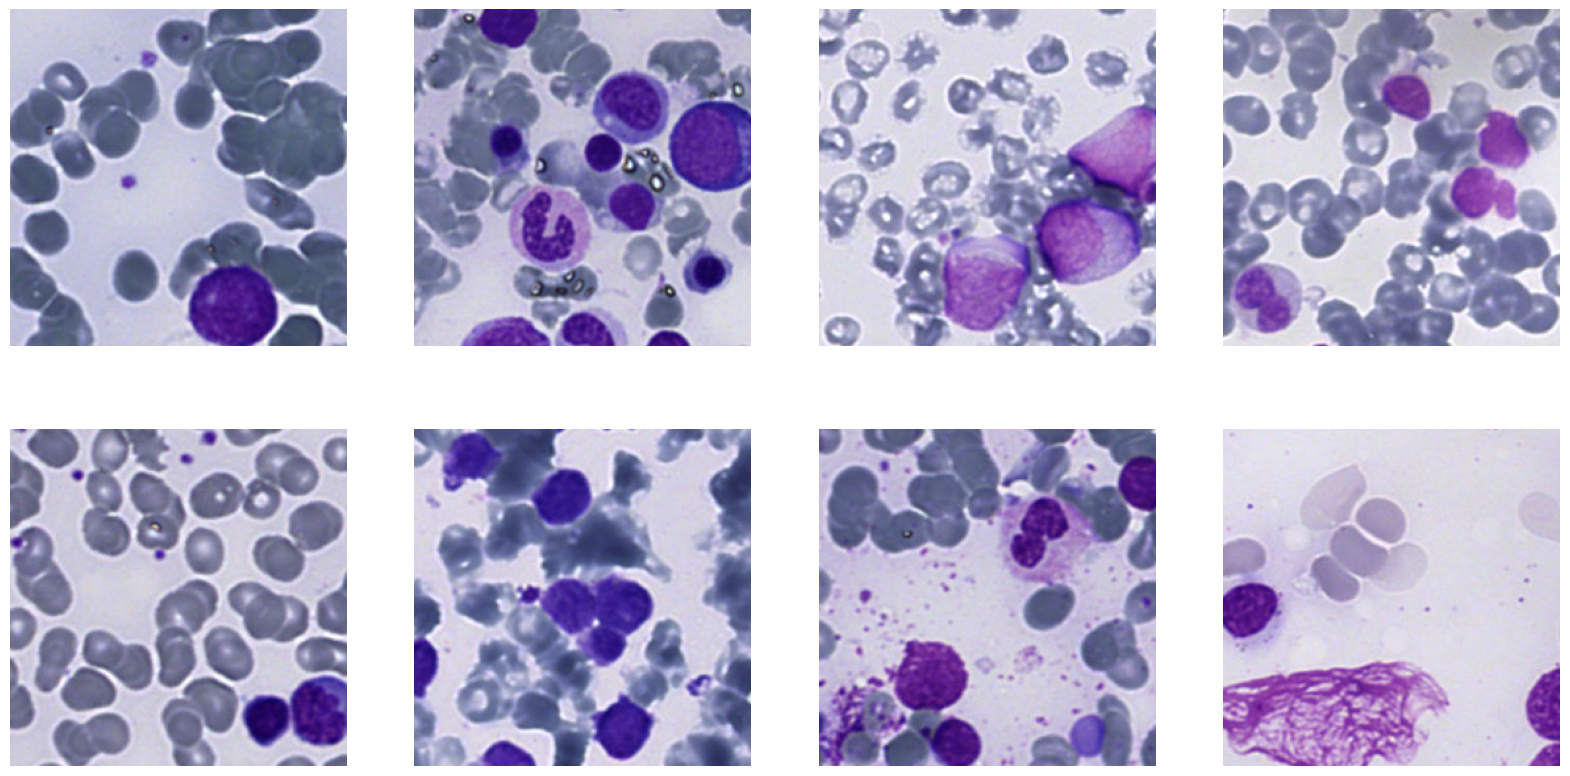

In [7]:
fig = plt.figure(figsize=(20, 10))
for img in val_ds.take(1):

    for i in range(8):
        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(img[i].numpy())
        ax.axis('off')

In [9]:
EPOCHS = 100
WU_EPOCHS = 10

steps_per_epoch = train_ds.cardinality().numpy()

wu_lr_function =  WarmUp(
    tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3, decay_steps=(EPOCHS - WU_EPOCHS) * steps_per_epoch
    ),
    start_lr=1e-4,
    target_lr=1e-3,
    warmup_steps=WU_EPOCHS * steps_per_epoch,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=wu_lr_function)

In [10]:
LDM = LatentDiffusionModel(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    batch_size=BATCH_SIZE,
    mean=mean,
    variance=variance,
    output_classes=3,
    latent_image_shape=(32, 32, 3),
    initial_dim = 96,
    depths = [4, 8, 4]
)
LDM.compile(optimizer=optimizer)


In [11]:
LDM.denoiser.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 1, 1)]    0           []                               
                                                                                                  
 Input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sinusoidal_embedding (Sinusoid  (None, 1, 1, 48)    0           ['input_1[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 48)   192         ['Input[0][0]']              

In [ ]:
history = LDM.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, 
                    callbacks=[
                                tf.keras.callbacks.ModelCheckpoint(
                                    "saved_model/diffusion_model/",
                                    save_weights_only=True,
                                    save_best_only=True,
                                    monitor='val_reconstruction_loss',
                                    mode="min",
                                ),
                                tf.keras.callbacks.EarlyStopping(
                                    monitor="val_reconstruction_loss",
                                    min_delta=1e-4,
                                    patience=20,
                                    verbose=True,
                                    mode="min",
                                    baseline=None,
                                    restore_best_weights=True,
                                ),
                                tf.keras.callbacks.LambdaCallback(on_epoch_end=LDM.plot_images),
                            ],)